#Adaptive Neurostimulation with Epileptor, Reinforcement Learning

This program will use real-time LFP data from the Epileptor model to find the ideal parameters for
neurostimulation. The state space will be composed of a discretized (partitioned) set of state variables 
acquired from the analysis of the LFP signals. The action space will be a discrete set of amplitudes and 
frequencies. The reward function will include seizure indicators and a negative term for power use.

In [1]:
%pylab nbagg
from tvb.simulator.lab import *


Populating the interactive namespace from numpy and matplotlib
   INFO  log level set to INFO


I have created a library with a few very useful functions for The Virtual Brain. This can be found in sim.py.

In [2]:
import sim

#Extracting Features from LFP
Here's some code to extract a few features (mean, min/max, range, power) from an LFP signal.
The first ~2000 ms of the LFP data should be cropped prior to being sent to this function.

In [38]:
def extract_features(raw_time, raw_data):
    data_min = np.min(raw_data[:],0)[0]
    data_max = np.max(raw_data[:],0)[0]
    data_rng = data_max - data_min
    data_avg = np.mean(raw_data[:], 0)[0]
    return (data_min, data_max, data_rng, data_avg)

#Set up the Q-learning algorithm

First, we need to decide on the states we have:
In the case where only [9] is epileptic

    -3 < mins < 1
    -1 < maxs < 3
     0 < rng  < 4
    -2 < avg  < 2
     0 < pwr  < dt * max_amp**2 = 10 * 400
    
So, for now, let's split each into two and get 16 states.
Use a 4-dimensional vector, where 0 indicates the lower values
and 1 indicates higher values.

*Note: for ease of coding, I started with a modified state
vector with only 6 possible states based on averages*

For actions, let's use these:

    0: 0 amp, 0 pulse width
    1: 1 amp, 2.5 p.w., 5 period
    2: 1 amp, 5 p.w., 10 period
    3: 5 amp, 10 p.w., 10 period

For rewards, I did some arbitrary things. The main assumption
here was that:

    (avg < 0) == seizure

Also, I didn't set the negative stimulation reward to be proportional
to power because I don't think that's true. But I'm also not
a neuroscientist.

General parameters for Q-learning are:

    gamma = greediness, ~1 is not greedy
    alpha = learning rate, ~0.2 for now
    epsilon = likelihood to do random things! ~0.1
    
This has been rather useful:
https://studywolf.wordpress.com/2012/11/25/reinforcement-learning-q-learning-and-exploration/

In [39]:
gamma = 0.9
alpha = 0.2
epsilon = 0
q_table = {}
actions = [0,6]

In [40]:
def state_vector_complicated(region, features):
    
    s_vector = [0,0,0,0]
    
    #minimum
    if features[0][region][0] < -1:
        s_vector[0] = 0
    else:
        s_vector[0] = 1
        
    #maximum 
    if features[1][region][0] < 1:
        s_vector[1] = 0
    else:
        s_vector[1] = 1
    
    #average
    if features[2][region][0] < 0:
        s_vector[2] = 0
    else: 
        s_vector[2] = 1
    
    power = features[4] * features[3]**2
    
    #power
#    if power == 0:
#        s_vector[3] = 0
#    elif power <= 5:
#        s_vector[3] = 1
#    else:
#        s_vector[3] = 2
    s_vector[3] = power
    
    return (s_vector[0], s_vector[1], s_vector[2], s_vector[3])
    

Simplified state vector using only average - this will be easier to code for now as it 
gives a total of only 6 states.

In [41]:
def state_vector(region, features, oldstate, olderstate):
    s_vector = [0,0]
    if features[2][region][0] < 0:
        s_vector[0] = 0
    else:
        s_vector[0] = 1
        
    power = features[4] * features[3]**2 #time * amp^2
    
    
    #for actions above, power is 0, 5 or 250
    
#    if power == 0:
#        s_vector[1] = 0
#    elif power < 10:
#        s_vector[1] = 1
#    else:
#        s_vector[1] = 2
 
    s_vector[1] = power
    
#    return (s_vector[0],oldstate[0],olderstate[1], s_vector[1])
    return  (s_vector[0],0,0, s_vector[1])


Reward function for a given state

In [42]:
def get_reward(s_vector):
    
    #seizure is -100 reward
    if  s_vector[0] == 0:
        reward = -100
    else:
        reward = 0
    
    #power reward proportional to negative power 
    
    if s_vector[3] == 0:
        reward += 0
    elif s_vector[3] <= 5:
        reward -= 5  * 0.2   #arbitrary!
    elif s_vector[3] <= 20:
        reward -= 25 * 0.2
    else:
        reward -= 125 * 0.2
        
    return reward

Some functions to get, update, and learn the q values of state-action pairs

In [43]:
def get_q(s_vector, action):
    return q_table.get((s_vector, action), 0)
    
def update_q(s_vector, action, newval):
    q_table[(s_vector,action)] = newval

def learn_from_experience(s_1, action, s_2, reward):
    oldval = get_q(s_1, action)
    
    maxq_newstate = max([get_q(s_2, a) for a in actions]) # = V(s') 
    
    # Q(s,a) <- Q(s,a) + alpha * [reward + gamma * V(s') - Q(s,a)]
    
    newval = oldval + alpha * (get_reward(s_2) + gamma * maxq_newstate - oldval)
    #should it be different for the first try??
    
    update_q(s_1, action, newval)
    
    

So now, we can tackle the action choosing problem.

In [44]:
def choose_action(state):
    if random.random() < epsilon:
        action = random.choice(actions)
   
    else:
        q = [get_q(state, a) for a in actions]
        max_q = max(q)
        count = q.count(max_q)
        if count == 1:
            i = q.index(max_q)
        else:
            best_acts = [i for i in range(len(actions)) if q[i] == max_q]
            i = random.choice(best_acts)
        action = actions[i]
    
    return action

Interface between action and stimulus parameters. As described above:

    0: 0 amp, 0 pulse width
    1: 1 amp, 2.5 p.w., 5 period
    2: 1 amp, 5 p.w., 10 period
    3: 5 amp, 10 p.w., 10 period

In [45]:
def get_freq_amp(action_log):
    freq = []
    amp = []
    for action in action_log:
        if action == 0:
            freq.append(0)
            amp.append(0)
        if action == 1:
            freq.append(500)
            amp.append(1)
        if action == 2:
            freq.append(250)
            amp.append(1)
        if action == 3:
            freq.append(500)
            amp.append(2)
        if action == 4:
            freq.append(250)
            amp.append(2)
        if action == 5:
            freq.append(500)
            amp.append(5)
        if action == 6:
            freq.append(250)
            amp.append(5)
        
    return (amp, freq)

In [46]:
def set_stim_parameters(action, stim):
    if action == 0:
        stim.temporal.parameters["amp"] = 0
        stim.temporal.parameters["T"] = 10
        stim.temporal.parameters["tau"] = 0
        # Power = 0
        
    elif action == 1:
        stim.temporal.parameters["amp"] = 1
        stim.temporal.parameters["T"] = 5
        stim.temporal.parameters["tau"] = 2.5
        # Power = 5
        
    elif action == 2:
        stim.temporal.parameters["amp"] = 1
        stim.temporal.parameters["T"] = 10
        stim.temporal.parameters["tau"] = 5
        # Power = 5
        
    elif action == 3:
        stim.temporal.parameters["amp"] = 2
        stim.temporal.parameters["T"] = 5
        stim.temporal.parameters["tau"] = 2.5 
        # Power = 20
        
    elif action == 4:
        stim.temporal.parameters["amp"] = 2
        stim.temporal.parameters["T"] = 10
        stim.temporal.parameters["tau"] = 5
        # Power = 20   
        
    elif action == 5:
        stim.temporal.parameters["amp"] = 5
        stim.temporal.parameters["T"] = 5
        stim.temporal.parameters["tau"] = 2.5
        # Power = 125
            
    elif action == 6:
        stim.temporal.parameters["amp"] = 20
        stim.temporal.parameters["T"] = 10
        stim.temporal.parameters["tau"] = 10
        # Power = 125

#Set up test simulation
Just set one epileptic region for now, for simplicity

In [47]:
epileptic = [9]
almost_epileptic = []
stimulus_target = [9]
stimulus_amplitude = 20
stimulus_weight = 2 #0-2 for each region
onset = 0
period = 500
pulse_width = 0
sim_time = 100000


(s, stimulus) = sim.set_sim(epileptic, almost_epileptic, stimulus_target, stimulus_amplitude, 
              stimulus_weight, onset, period, pulse_width, sim_time)

WARNING  File 'hemispheres' not found in ZIP.


This is useful to get rid of the noisy initial conditions - just discard the first 3000 seconds

In [48]:
s.run(simulation_length=3000)
print("")

In [49]:
dt = 10
(tt, aa), (xx, xy), (yy, yx) = s.run(simulation_length = 1) #too lazy to properly initialize the array
i = 0
mins, maxs, rng, avg = [], [], [], []

for i in range(76):
    mins.append([])
    maxs.append([])
    rng.append([])
    avg.append([])

    
states = []
action_log = []
action = 0

#Adaptive Loop
Loop through the simulation, fixing stimulation parameters at every iteration

In [50]:
for i in range(1000):
    
    if i%10 == 0:
        print "\ntime is: " + str(i*dt)
    
    (t, a), (x1, x2), (y1, y2) = s.run(simulation_length = dt)
    
    
    #extract_features should be edited later so we just have one tuple
    (imins, imaxs, irng, iavg) = extract_features(t,a)
    features = (imins, imaxs, iavg, stimulus.temporal.parameters["amp"], 
                (dt/stimulus.temporal.parameters["T"])*stimulus.temporal.parameters["tau"]) 
                #amount of time stimulated per dt
    if i > 1:
        states.append( state_vector(9, features, states[i-1], states[i-2]) )
    else:
        states.append( state_vector(9, features, (1,1,1,0), (1,1,1,0)))
    
    if i != 0:
        learn_from_experience(states[i-1], action, states[i], get_reward(states[i]))
    
    action = choose_action(states[i])
    action_log.append(action)
    
    set_stim_parameters(action, stimulus)
    
    
    
    length = len(tt)
    tt = np.append(tt, t, axis=0)
    aa = np.append(aa, a, axis=0)
    
    for c in range(76):
        mins[c].append(imins[c][0])
        maxs[c].append(imaxs[c][0])
        rng[c].append(irng[c][0])
        avg[c].append(iavg[c][0])



time is: 0

time is: 100

time is: 200

time is: 300

time is: 400

time is: 500

time is: 600

time is: 700

time is: 800

time is: 900

time is: 1000

time is: 1100

time is: 1200

time is: 1300

time is: 1400

time is: 1500

time is: 1600

time is: 1700

time is: 1800

time is: 1900

time is: 2000

time is: 2100

time is: 2200

time is: 2300

time is: 2400

time is: 2500

time is: 2600

time is: 2700

time is: 2800

time is: 2900

time is: 3000

time is: 3100

time is: 3200

time is: 3300

time is: 3400

time is: 3500

time is: 3600

time is: 3700

time is: 3800

time is: 3900

time is: 4000

time is: 4100

time is: 4200

time is: 4300

time is: 4400

time is: 4500

time is: 4600

time is: 4700

time is: 4800

time is: 4900

time is: 5000

time is: 5100

time is: 5200

time is: 5300

time is: 5400

time is: 5500

time is: 5600

time is: 5700

time is: 5800

time is: 5900

time is: 6000

time is: 6100

time is: 6200

time is: 6300

time is: 6400

time is: 6500

time is: 6600

time i

<IPython.core.display.Javascript object>


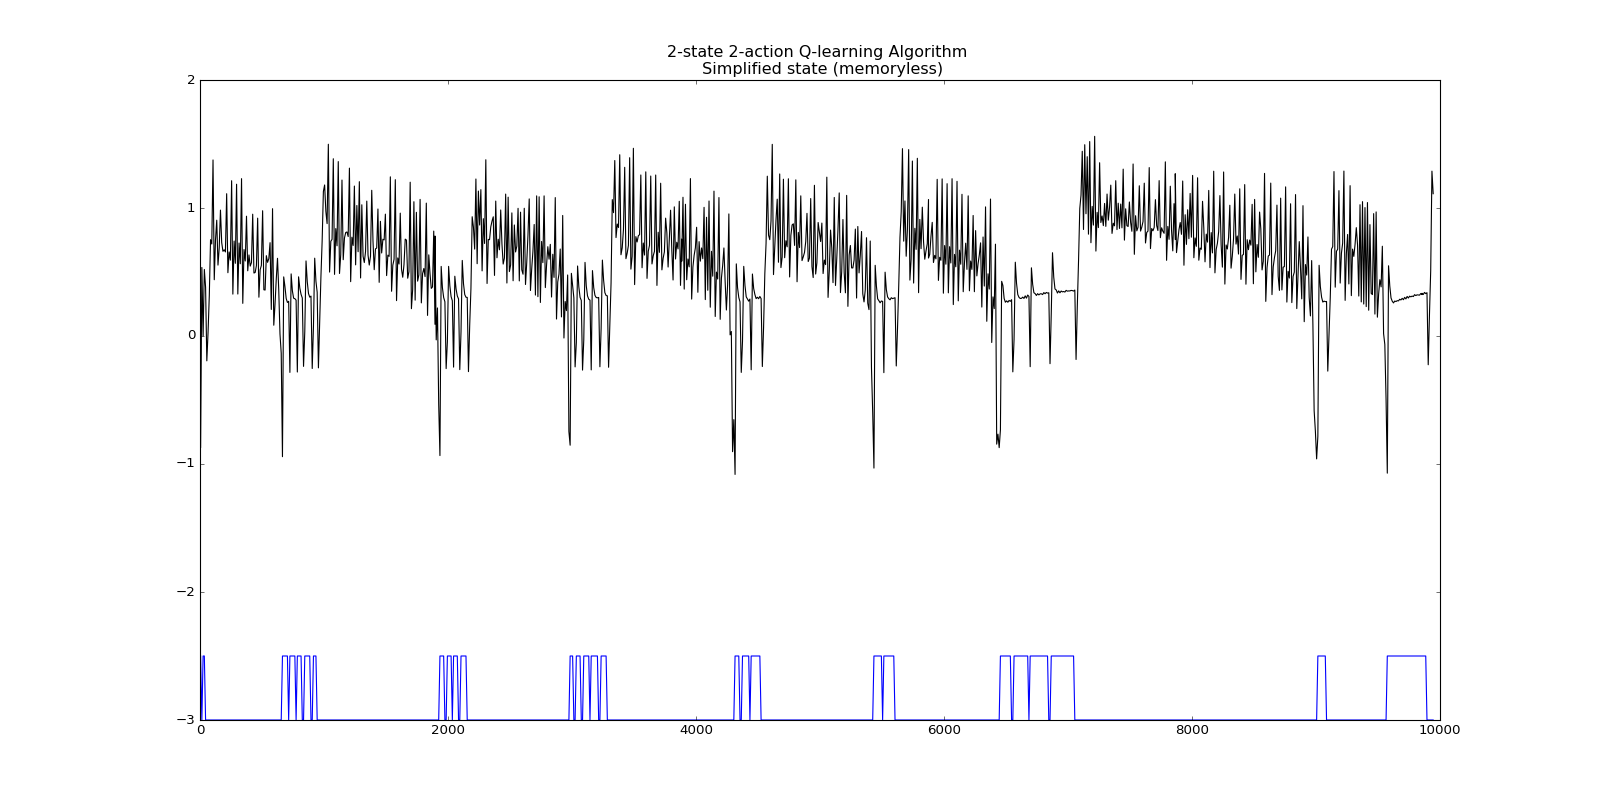

In [52]:
figure = figsize(20, 10)
#plot(tt[:]-3000, aa[:,0,9,:], 'r')
plot(10*(tt[1:(len(avg[9])+1)]-3000),avg[9], 'k')
#plot(10*(tt[1:(len(avg[9])+1)]-3000), np.array(action_log)/6. - 3, 'k')
(amp_plot, freq_plot) = get_freq_amp(action_log)
plot(10*(tt[1:(len(avg[9])+1)]-3000), np.array(amp_plot)/10. - 3, 'b')
#plot(10*(tt[1:(len(avg[9])+1)]-3000), np.array(freq_plot)/200. - 3, 'g')
title("2-state 2-action Q-learning Algorithm \n Simplified state (memoryless)")
#savefig("Graphs/2state2action-memoryless")
show()



In [33]:
action_log

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [53]:
q_table

{((0, 0, 0, 0), 0): -167.5132729005706,
 ((0, 0, 0, 0), 6): -202.67957435987708,
 ((1, 0, 0, 0), 0): -60.684408936620464,
 ((1, 0, 0, 0), 6): -102.6043853634768,
 ((1, 0, 0, 4000), 0): -248.1121933332389,
 ((1, 0, 0, 4000), 6): -241.43564522801785}

# FFT 
FFT might be useful to extract some features. Here's some code to do that

In [1]:
def extract_fft(d):
    
    fd = []
    for i in range(76):
        fd.append([])
    
    for dt in d:
        i = 0
        for region in dt[0]:
            fd[i].append(region[0])
            i += 1
        
    data_fft = []
    for region in fd:
        data_fft.append(fft.rfft(region))
        
    return data_fft

plot_times = []
indicators = []
i = 0

for i in range(76):
    plot_times.append(np.fft.rfftfreq(3000))



fft_data = extract_fft(taraw[2000:])
plot(plot_times[9], fft_data[9], plot_times[1], fft_data[1])
show()


NameError: name 'np' is not defined